# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network class

* Generator
* Discriminator


In [37]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        h = F.relu(self.fc1(z.view(-1, 20)))
        probabilities =torch.sigmoid(self.fc2(h))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        h=F.relu(self.fc1(x.view(-1, 784)))
        probabilities = torch.sigmoid(self.fc2(h))
        return probabilities

# Loss Function

In [38]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [39]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
  # Lists to keep track of progress
    G_losses = []
    D_losses = []
    
    print("Starting Training Loop...")
    
    for batch_idx, (data, _) in enumerate(train_loader):
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = gan_loss_function(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 20, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(0)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = gan_loss_function(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = gan_loss_function(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        if batch_idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, batch_idx, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
    average_discriminator_loss = sum(G_losses)/len(G_losses)
    average_generator_loss = sum(D_losses)/len(D_losses)
    return average_generator_loss, average_discriminator_loss


# Testing


In [40]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    
    print("Starting Training Loop...")
    
    for batch_idx, (data, _) in enumerate(test_loader):
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = gan_loss_function(output, label)
        

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 20, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(0)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = gan_loss_function(output, label)
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = gan_loss_function(output, label)
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
    average_discriminator_loss = sum(G_losses)/len(G_losses)
    average_generator_loss = sum(D_losses)/len(D_losses)  
    return average_generator_loss, average_discriminator_loss

# Main

Starting Training Loop...
[1/50][0/469]	Loss_D: 1.3594	Loss_G: 1.6970	D(x): 0.4845	D(G(z)): 0.4699 / 0.1832
[1/50][50/469]	Loss_D: 2.3149	Loss_G: 0.2112	D(x): 0.4524	D(G(z)): 0.7816 / 0.8096
[1/50][100/469]	Loss_D: 2.3985	Loss_G: 2.5138	D(x): 0.0993	D(G(z)): 0.0847 / 0.0810
[1/50][150/469]	Loss_D: 0.1802	Loss_G: 2.6705	D(x): 0.9213	D(G(z)): 0.0936 / 0.0692
[1/50][200/469]	Loss_D: 0.0964	Loss_G: 3.0329	D(x): 0.9775	D(G(z)): 0.0710 / 0.0482
[1/50][250/469]	Loss_D: 0.1575	Loss_G: 2.4946	D(x): 0.9955	D(G(z)): 0.1419 / 0.0825
[1/50][300/469]	Loss_D: 0.0300	Loss_G: 4.8185	D(x): 0.9806	D(G(z)): 0.0104 / 0.0081
[1/50][350/469]	Loss_D: 0.3636	Loss_G: 3.2648	D(x): 0.7309	D(G(z)): 0.0488 / 0.0382
[1/50][400/469]	Loss_D: 0.0464	Loss_G: 3.7843	D(x): 0.9986	D(G(z)): 0.0440 / 0.0227
[1/50][450/469]	Loss_D: 0.1006	Loss_G: 2.7146	D(x): 0.9641	D(G(z)): 0.0620 / 0.0662
Starting Training Loop...
Sample of generated images


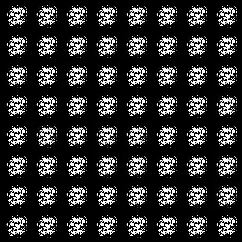



Starting Training Loop...
[2/50][0/469]	Loss_D: 0.0097	Loss_G: 5.3241	D(x): 0.9953	D(G(z)): 0.0049 / 0.0049
[2/50][50/469]	Loss_D: 0.0054	Loss_G: 5.6519	D(x): 0.9989	D(G(z)): 0.0043 / 0.0035
[2/50][100/469]	Loss_D: 0.0386	Loss_G: 3.7354	D(x): 0.9998	D(G(z)): 0.0377 / 0.0239
[2/50][150/469]	Loss_D: 0.0380	Loss_G: 3.4531	D(x): 0.9954	D(G(z)): 0.0328 / 0.0316
[2/50][200/469]	Loss_D: 0.0192	Loss_G: 4.6852	D(x): 0.9923	D(G(z)): 0.0115 / 0.0092
[2/50][250/469]	Loss_D: 0.0251	Loss_G: 3.4190	D(x): 1.0000	D(G(z)): 0.0248 / 0.0327
[2/50][300/469]	Loss_D: 3.8539	Loss_G: 10.3462	D(x): 0.0212	D(G(z)): 0.0000 / 0.0000
[2/50][350/469]	Loss_D: 0.0026	Loss_G: 7.5044	D(x): 0.9985	D(G(z)): 0.0011 / 0.0006
[2/50][400/469]	Loss_D: 0.0022	Loss_G: 7.1530	D(x): 0.9989	D(G(z)): 0.0011 / 0.0008
[2/50][450/469]	Loss_D: 0.0010	Loss_G: 9.8606	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
Starting Training Loop...
Sample of generated images


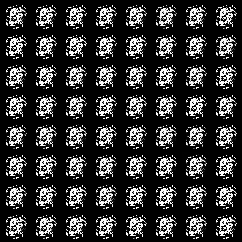



Starting Training Loop...
[3/50][0/469]	Loss_D: 0.0005	Loss_G: 9.0138	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[3/50][50/469]	Loss_D: 0.0102	Loss_G: 4.7292	D(x): 0.9989	D(G(z)): 0.0090 / 0.0088
[3/50][100/469]	Loss_D: 0.0014	Loss_G: 8.6408	D(x): 0.9990	D(G(z)): 0.0004 / 0.0002
[3/50][150/469]	Loss_D: 0.0055	Loss_G: 9.0619	D(x): 0.9947	D(G(z)): 0.0001 / 0.0001
[3/50][200/469]	Loss_D: 0.0015	Loss_G: 6.9291	D(x): 0.9999	D(G(z)): 0.0013 / 0.0010
[3/50][250/469]	Loss_D: 0.0003	Loss_G: 14.2733	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[3/50][300/469]	Loss_D: 0.0001	Loss_G: 13.3213	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[3/50][350/469]	Loss_D: 0.0001	Loss_G: 11.5060	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][400/469]	Loss_D: 0.0027	Loss_G: 7.1001	D(x): 0.9987	D(G(z)): 0.0014 / 0.0008
[3/50][450/469]	Loss_D: 0.0061	Loss_G: 5.4922	D(x): 0.9997	D(G(z)): 0.0058 / 0.0041
Starting Training Loop...
Sample of generated images


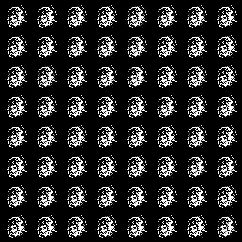



Starting Training Loop...
[4/50][0/469]	Loss_D: 0.0014	Loss_G: 6.9616	D(x): 0.9997	D(G(z)): 0.0011 / 0.0009
[4/50][50/469]	Loss_D: 0.0025	Loss_G: 13.1692	D(x): 0.9975	D(G(z)): 0.0000 / 0.0000
[4/50][100/469]	Loss_D: 0.0056	Loss_G: 12.3813	D(x): 0.9944	D(G(z)): 0.0000 / 0.0000
[4/50][150/469]	Loss_D: 0.0001	Loss_G: 9.7743	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[4/50][200/469]	Loss_D: 0.0010	Loss_G: 8.3133	D(x): 0.9994	D(G(z)): 0.0004 / 0.0002
[4/50][250/469]	Loss_D: 0.0079	Loss_G: 5.6459	D(x): 0.9963	D(G(z)): 0.0042 / 0.0035
[4/50][300/469]	Loss_D: 0.0063	Loss_G: 6.1427	D(x): 0.9989	D(G(z)): 0.0052 / 0.0021
[4/50][350/469]	Loss_D: 0.0347	Loss_G: 4.0834	D(x): 0.9850	D(G(z)): 0.0194 / 0.0169
[4/50][400/469]	Loss_D: 0.0043	Loss_G: 5.6074	D(x): 0.9999	D(G(z)): 0.0042 / 0.0037
[4/50][450/469]	Loss_D: 0.0687	Loss_G: 8.0198	D(x): 0.9340	D(G(z)): 0.0004 / 0.0003
Starting Training Loop...
Sample of generated images


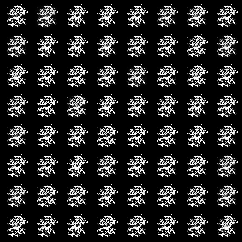



Starting Training Loop...
[5/50][0/469]	Loss_D: 0.0769	Loss_G: 2.9688	D(x): 0.9999	D(G(z)): 0.0739 / 0.0514
[5/50][50/469]	Loss_D: 0.0324	Loss_G: 3.6586	D(x): 0.9992	D(G(z)): 0.0311 / 0.0258
[5/50][100/469]	Loss_D: 0.0106	Loss_G: 4.2955	D(x): 1.0000	D(G(z)): 0.0105 / 0.0136
[5/50][150/469]	Loss_D: 0.0262	Loss_G: 5.7212	D(x): 0.9798	D(G(z)): 0.0058 / 0.0033
[5/50][200/469]	Loss_D: 0.2687	Loss_G: 1.2903	D(x): 0.9999	D(G(z)): 0.2356 / 0.2752
[5/50][250/469]	Loss_D: 0.0990	Loss_G: 5.3852	D(x): 0.9136	D(G(z)): 0.0086 / 0.0046
[5/50][300/469]	Loss_D: 0.0691	Loss_G: 3.3718	D(x): 0.9998	D(G(z)): 0.0666 / 0.0343
[5/50][350/469]	Loss_D: 0.0529	Loss_G: 7.4257	D(x): 0.9493	D(G(z)): 0.0009 / 0.0006
[5/50][400/469]	Loss_D: 0.0146	Loss_G: 4.7279	D(x): 0.9998	D(G(z)): 0.0143 / 0.0088
[5/50][450/469]	Loss_D: 0.0002	Loss_G: 8.9774	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
Starting Training Loop...
Sample of generated images


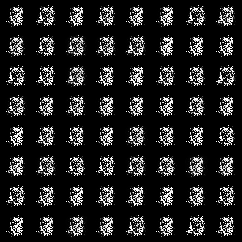



Starting Training Loop...
[6/50][0/469]	Loss_D: 0.0095	Loss_G: 9.3008	D(x): 0.9908	D(G(z)): 0.0002 / 0.0001
[6/50][50/469]	Loss_D: 0.0019	Loss_G: 7.3811	D(x): 0.9990	D(G(z)): 0.0009 / 0.0006
[6/50][100/469]	Loss_D: 0.0014	Loss_G: 6.6352	D(x): 1.0000	D(G(z)): 0.0014 / 0.0013
[6/50][150/469]	Loss_D: 0.0002	Loss_G: 13.2553	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[6/50][200/469]	Loss_D: 0.5331	Loss_G: 2.3015	D(x): 0.6941	D(G(z)): 0.1545 / 0.1001
[6/50][250/469]	Loss_D: 0.0234	Loss_G: 3.9583	D(x): 1.0000	D(G(z)): 0.0231 / 0.0191
[6/50][300/469]	Loss_D: 0.0259	Loss_G: 4.0294	D(x): 0.9930	D(G(z)): 0.0187 / 0.0178
[6/50][350/469]	Loss_D: 0.3699	Loss_G: 11.8168	D(x): 0.6908	D(G(z)): 0.0000 / 0.0000
[6/50][400/469]	Loss_D: 0.0249	Loss_G: 3.8338	D(x): 1.0000	D(G(z)): 0.0246 / 0.0216
[6/50][450/469]	Loss_D: 0.0020	Loss_G: 7.3893	D(x): 0.9993	D(G(z)): 0.0012 / 0.0006
Starting Training Loop...
Sample of generated images


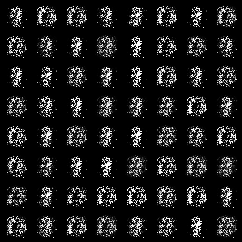



Starting Training Loop...
[7/50][0/469]	Loss_D: 0.0545	Loss_G: 3.4316	D(x): 1.0000	D(G(z)): 0.0530 / 0.0323
[7/50][50/469]	Loss_D: 0.0021	Loss_G: 6.8649	D(x): 1.0000	D(G(z)): 0.0021 / 0.0010
[7/50][100/469]	Loss_D: 0.2435	Loss_G: 4.4403	D(x): 0.7934	D(G(z)): 0.0120 / 0.0118
[7/50][150/469]	Loss_D: 0.0296	Loss_G: 12.0445	D(x): 0.9709	D(G(z)): 0.0000 / 0.0000
[7/50][200/469]	Loss_D: 0.0192	Loss_G: 5.1624	D(x): 0.9896	D(G(z)): 0.0086 / 0.0057
[7/50][250/469]	Loss_D: 0.2570	Loss_G: 2.5653	D(x): 0.8534	D(G(z)): 0.0938 / 0.0769
[7/50][300/469]	Loss_D: 0.1394	Loss_G: 2.2440	D(x): 0.9988	D(G(z)): 0.1291 / 0.1060
[7/50][350/469]	Loss_D: 1.6417	Loss_G: 0.7066	D(x): 0.9211	D(G(z)): 0.7898 / 0.4933
[7/50][400/469]	Loss_D: 0.0284	Loss_G: 4.0599	D(x): 0.9992	D(G(z)): 0.0272 / 0.0173
[7/50][450/469]	Loss_D: 0.0752	Loss_G: 3.4528	D(x): 0.9944	D(G(z)): 0.0672 / 0.0317
Starting Training Loop...
Sample of generated images


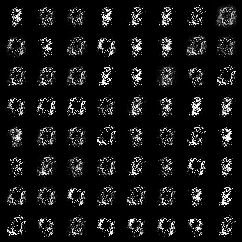



Starting Training Loop...
[8/50][0/469]	Loss_D: 0.3178	Loss_G: 3.7980	D(x): 0.7546	D(G(z)): 0.0355 / 0.0224
[8/50][50/469]	Loss_D: 3.3268	Loss_G: 1.9049	D(x): 0.0529	D(G(z)): 0.3215 / 0.1488
[8/50][100/469]	Loss_D: 0.1498	Loss_G: 3.6043	D(x): 0.8886	D(G(z)): 0.0312 / 0.0272
[8/50][150/469]	Loss_D: 0.0920	Loss_G: 6.9946	D(x): 0.9130	D(G(z)): 0.0010 / 0.0009
[8/50][200/469]	Loss_D: 0.0313	Loss_G: 3.7487	D(x): 0.9999	D(G(z)): 0.0307 / 0.0235
[8/50][250/469]	Loss_D: 0.1019	Loss_G: 2.6606	D(x): 0.9999	D(G(z)): 0.0968 / 0.0699
[8/50][300/469]	Loss_D: 0.6005	Loss_G: 1.3014	D(x): 0.9715	D(G(z)): 0.4354 / 0.2722
[8/50][350/469]	Loss_D: 0.0507	Loss_G: 3.2145	D(x): 0.9997	D(G(z)): 0.0491 / 0.0402
[8/50][400/469]	Loss_D: 0.2820	Loss_G: 2.4016	D(x): 0.8422	D(G(z)): 0.1044 / 0.0906
[8/50][450/469]	Loss_D: 1.2164	Loss_G: 3.6507	D(x): 0.3040	D(G(z)): 0.0252 / 0.0260
Starting Training Loop...
Sample of generated images


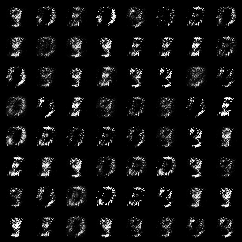



Starting Training Loop...
[9/50][0/469]	Loss_D: 0.1835	Loss_G: 2.1368	D(x): 0.9502	D(G(z)): 0.1241 / 0.1180
[9/50][50/469]	Loss_D: 0.4217	Loss_G: 1.4984	D(x): 0.9999	D(G(z)): 0.3440 / 0.2235
[9/50][100/469]	Loss_D: 0.2419	Loss_G: 1.7318	D(x): 1.0000	D(G(z)): 0.2149 / 0.1770
[9/50][150/469]	Loss_D: 0.3960	Loss_G: 1.5227	D(x): 0.8846	D(G(z)): 0.2393 / 0.2181
[9/50][200/469]	Loss_D: 0.2098	Loss_G: 1.7467	D(x): 1.0000	D(G(z)): 0.1892 / 0.1743
[9/50][250/469]	Loss_D: 0.6158	Loss_G: 1.2423	D(x): 0.9795	D(G(z)): 0.4485 / 0.2887
[9/50][300/469]	Loss_D: 0.0489	Loss_G: 3.2431	D(x): 0.9972	D(G(z)): 0.0450 / 0.0390
[9/50][350/469]	Loss_D: 0.0366	Loss_G: 5.5374	D(x): 0.9724	D(G(z)): 0.0085 / 0.0039
[9/50][400/469]	Loss_D: 1.5079	Loss_G: 1.5796	D(x): 0.2841	D(G(z)): 0.2209 / 0.2061
[9/50][450/469]	Loss_D: 0.6702	Loss_G: 1.2939	D(x): 0.8909	D(G(z)): 0.4257 / 0.2742
Starting Training Loop...
Sample of generated images


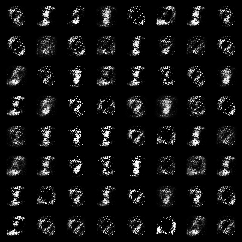



Starting Training Loop...
[10/50][0/469]	Loss_D: 0.2715	Loss_G: 1.8874	D(x): 0.9342	D(G(z)): 0.1841 / 0.1515
[10/50][50/469]	Loss_D: 0.0643	Loss_G: 3.2402	D(x): 0.9999	D(G(z)): 0.0622 / 0.0392
[10/50][100/469]	Loss_D: 0.1714	Loss_G: 1.9416	D(x): 1.0000	D(G(z)): 0.1575 / 0.1435
[10/50][150/469]	Loss_D: 2.3627	Loss_G: 2.9386	D(x): 0.0997	D(G(z)): 0.0554 / 0.0529
[10/50][200/469]	Loss_D: 0.0286	Loss_G: 3.6115	D(x): 0.9996	D(G(z)): 0.0278 / 0.0270
[10/50][250/469]	Loss_D: 0.0092	Loss_G: 4.7910	D(x): 1.0000	D(G(z)): 0.0091 / 0.0083
[10/50][300/469]	Loss_D: 0.9687	Loss_G: 7.6245	D(x): 0.3798	D(G(z)): 0.0006 / 0.0005
[10/50][350/469]	Loss_D: 0.0323	Loss_G: 3.4479	D(x): 0.9999	D(G(z)): 0.0317 / 0.0318
[10/50][400/469]	Loss_D: 0.0876	Loss_G: 3.0754	D(x): 1.0000	D(G(z)): 0.0839 / 0.0462
[10/50][450/469]	Loss_D: 0.2310	Loss_G: 1.7603	D(x): 0.9937	D(G(z)): 0.2013 / 0.1720
Starting Training Loop...
Sample of generated images


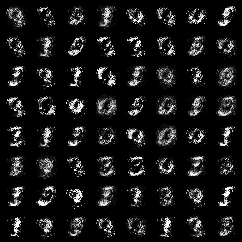



Starting Training Loop...
[11/50][0/469]	Loss_D: 0.0284	Loss_G: 3.9577	D(x): 1.0000	D(G(z)): 0.0280 / 0.0191
[11/50][50/469]	Loss_D: 0.3560	Loss_G: 4.4673	D(x): 0.7082	D(G(z)): 0.0110 / 0.0115
[11/50][100/469]	Loss_D: 0.0264	Loss_G: 3.5104	D(x): 0.9996	D(G(z)): 0.0256 / 0.0299
[11/50][150/469]	Loss_D: 1.8222	Loss_G: 0.4907	D(x): 0.7065	D(G(z)): 0.7712 / 0.6122
[11/50][200/469]	Loss_D: 0.1926	Loss_G: 2.0474	D(x): 1.0000	D(G(z)): 0.1752 / 0.1291
[11/50][250/469]	Loss_D: 1.3211	Loss_G: 1.7509	D(x): 0.4327	D(G(z)): 0.3833 / 0.1736
[11/50][300/469]	Loss_D: 1.3539	Loss_G: 1.4498	D(x): 0.4119	D(G(z)): 0.3731 / 0.2346
[11/50][350/469]	Loss_D: 0.5685	Loss_G: 7.3566	D(x): 0.5668	D(G(z)): 0.0009 / 0.0006
[11/50][400/469]	Loss_D: 0.1542	Loss_G: 2.4014	D(x): 1.0000	D(G(z)): 0.1429 / 0.0906
[11/50][450/469]	Loss_D: 0.3199	Loss_G: 2.2491	D(x): 0.8198	D(G(z)): 0.1142 / 0.1055
Starting Training Loop...
Sample of generated images


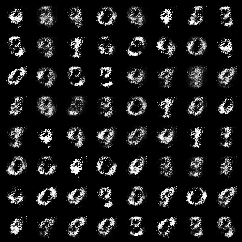



Starting Training Loop...
[12/50][0/469]	Loss_D: 0.1657	Loss_G: 2.6739	D(x): 0.9379	D(G(z)): 0.0966 / 0.0690
[12/50][50/469]	Loss_D: 1.0425	Loss_G: 3.7404	D(x): 0.3598	D(G(z)): 0.0202 / 0.0237
[12/50][100/469]	Loss_D: 0.5452	Loss_G: 0.9356	D(x): 0.9968	D(G(z)): 0.4184 / 0.3924
[12/50][150/469]	Loss_D: 0.1409	Loss_G: 2.2651	D(x): 0.9879	D(G(z)): 0.1207 / 0.1038
[12/50][200/469]	Loss_D: 0.2292	Loss_G: 2.1304	D(x): 0.9062	D(G(z)): 0.1225 / 0.1188
[12/50][250/469]	Loss_D: 0.2409	Loss_G: 2.4257	D(x): 0.8752	D(G(z)): 0.1020 / 0.0884
[12/50][300/469]	Loss_D: 0.8967	Loss_G: 1.2980	D(x): 0.5581	D(G(z)): 0.2691 / 0.2731
[12/50][350/469]	Loss_D: 0.7410	Loss_G: 2.2872	D(x): 0.5243	D(G(z)): 0.0909 / 0.1016
[12/50][400/469]	Loss_D: 0.6998	Loss_G: 1.6161	D(x): 0.6509	D(G(z)): 0.2368 / 0.1987
[12/50][450/469]	Loss_D: 0.0799	Loss_G: 3.3417	D(x): 0.9649	D(G(z)): 0.0432 / 0.0354
Starting Training Loop...
Sample of generated images


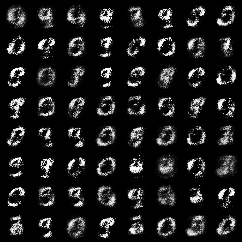



Starting Training Loop...
[13/50][0/469]	Loss_D: 0.2602	Loss_G: 3.7277	D(x): 0.7916	D(G(z)): 0.0261 / 0.0240
[13/50][50/469]	Loss_D: 0.3200	Loss_G: 1.4447	D(x): 0.9999	D(G(z)): 0.2738 / 0.2358
[13/50][100/469]	Loss_D: 0.3916	Loss_G: 1.2627	D(x): 0.9723	D(G(z)): 0.3048 / 0.2829
[13/50][150/469]	Loss_D: 2.0090	Loss_G: 1.5069	D(x): 0.1938	D(G(z)): 0.3079 / 0.2216
[13/50][200/469]	Loss_D: 0.3583	Loss_G: 1.2719	D(x): 0.9990	D(G(z)): 0.3004 / 0.2803
[13/50][250/469]	Loss_D: 1.8494	Loss_G: 1.5240	D(x): 0.2024	D(G(z)): 0.2227 / 0.2178
[13/50][300/469]	Loss_D: 0.0903	Loss_G: 2.6294	D(x): 0.9960	D(G(z)): 0.0827 / 0.0721
[13/50][350/469]	Loss_D: 0.4512	Loss_G: 3.2694	D(x): 0.6636	D(G(z)): 0.0403 / 0.0380
[13/50][400/469]	Loss_D: 1.1904	Loss_G: 2.4134	D(x): 0.3345	D(G(z)): 0.0909 / 0.0895
[13/50][450/469]	Loss_D: 1.6154	Loss_G: 1.0396	D(x): 0.2928	D(G(z)): 0.3211 / 0.3536
Starting Training Loop...
Sample of generated images


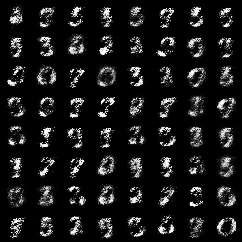



Starting Training Loop...
[14/50][0/469]	Loss_D: 0.2453	Loss_G: 4.5135	D(x): 0.7933	D(G(z)): 0.0137 / 0.0110
[14/50][50/469]	Loss_D: 0.1860	Loss_G: 2.7198	D(x): 0.8860	D(G(z)): 0.0629 / 0.0659
[14/50][100/469]	Loss_D: 1.2980	Loss_G: 4.6217	D(x): 0.2759	D(G(z)): 0.0104 / 0.0098
[14/50][150/469]	Loss_D: 0.4177	Loss_G: 1.5032	D(x): 0.8514	D(G(z)): 0.2265 / 0.2224
[14/50][200/469]	Loss_D: 0.3862	Loss_G: 1.3167	D(x): 0.9564	D(G(z)): 0.2894 / 0.2680
[14/50][250/469]	Loss_D: 0.9043	Loss_G: 0.9748	D(x): 0.6569	D(G(z)): 0.3837 / 0.3773
[14/50][300/469]	Loss_D: 1.0547	Loss_G: 1.6765	D(x): 0.4270	D(G(z)): 0.1843 / 0.1870
[14/50][350/469]	Loss_D: 0.2197	Loss_G: 1.8392	D(x): 0.9923	D(G(z)): 0.1909 / 0.1589
[14/50][400/469]	Loss_D: 0.6462	Loss_G: 2.9505	D(x): 0.5559	D(G(z)): 0.0573 / 0.0523
[14/50][450/469]	Loss_D: 1.1481	Loss_G: 0.4784	D(x): 0.9155	D(G(z)): 0.6535 / 0.6198
Starting Training Loop...
Sample of generated images


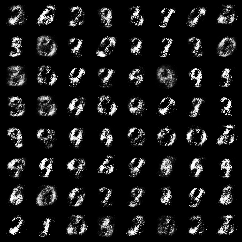



Starting Training Loop...
[15/50][0/469]	Loss_D: 0.2449	Loss_G: 1.7653	D(x): 0.9716	D(G(z)): 0.1944 / 0.1711
[15/50][50/469]	Loss_D: 0.8721	Loss_G: 0.7414	D(x): 0.9818	D(G(z)): 0.5742 / 0.4764
[15/50][100/469]	Loss_D: 0.2102	Loss_G: 2.4545	D(x): 0.9405	D(G(z)): 0.1384 / 0.0859
[15/50][150/469]	Loss_D: 2.3578	Loss_G: 3.0015	D(x): 0.0996	D(G(z)): 0.0503 / 0.0497
[15/50][200/469]	Loss_D: 0.5720	Loss_G: 2.9300	D(x): 0.5961	D(G(z)): 0.0531 / 0.0534
[15/50][250/469]	Loss_D: 0.7619	Loss_G: 1.1593	D(x): 0.6923	D(G(z)): 0.3257 / 0.3137
[15/50][300/469]	Loss_D: 0.3065	Loss_G: 2.2217	D(x): 0.8285	D(G(z)): 0.1116 / 0.1084
[15/50][350/469]	Loss_D: 0.5902	Loss_G: 1.1231	D(x): 0.9024	D(G(z)): 0.3858 / 0.3253
[15/50][400/469]	Loss_D: 0.4725	Loss_G: 1.3607	D(x): 0.9486	D(G(z)): 0.3428 / 0.2565
[15/50][450/469]	Loss_D: 0.0939	Loss_G: 2.6453	D(x): 0.9932	D(G(z)): 0.0833 / 0.0710
Starting Training Loop...
Sample of generated images


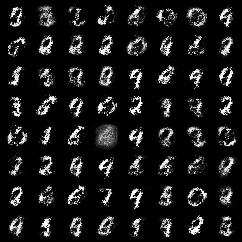



Starting Training Loop...
[16/50][0/469]	Loss_D: 0.9931	Loss_G: 1.3378	D(x): 0.5152	D(G(z)): 0.2810 / 0.2624
[16/50][50/469]	Loss_D: 0.4712	Loss_G: 1.3142	D(x): 0.9039	D(G(z)): 0.3094 / 0.2687
[16/50][100/469]	Loss_D: 0.3669	Loss_G: 2.1913	D(x): 0.7926	D(G(z)): 0.1258 / 0.1118
[16/50][150/469]	Loss_D: 0.0914	Loss_G: 2.6027	D(x): 1.0000	D(G(z)): 0.0873 / 0.0741
[16/50][200/469]	Loss_D: 3.1030	Loss_G: 2.8304	D(x): 0.0486	D(G(z)): 0.0750 / 0.0590
[16/50][250/469]	Loss_D: 0.5148	Loss_G: 3.6856	D(x): 0.6129	D(G(z)): 0.0250 / 0.0251
[16/50][300/469]	Loss_D: 0.1581	Loss_G: 1.9538	D(x): 0.9940	D(G(z)): 0.1411 / 0.1417
[16/50][350/469]	Loss_D: 0.1181	Loss_G: 2.3145	D(x): 0.9991	D(G(z)): 0.1106 / 0.0988
[16/50][400/469]	Loss_D: 0.1269	Loss_G: 2.6269	D(x): 0.9587	D(G(z)): 0.0813 / 0.0723
[16/50][450/469]	Loss_D: 0.2811	Loss_G: 2.0791	D(x): 0.8837	D(G(z)): 0.1456 / 0.1250
Starting Training Loop...
Sample of generated images


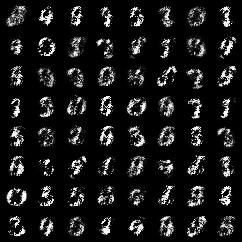



Starting Training Loop...
[17/50][0/469]	Loss_D: 0.7372	Loss_G: 3.1619	D(x): 0.5025	D(G(z)): 0.0479 / 0.0423
[17/50][50/469]	Loss_D: 0.1233	Loss_G: 3.5152	D(x): 0.9137	D(G(z)): 0.0324 / 0.0297
[17/50][100/469]	Loss_D: 0.1053	Loss_G: 2.4280	D(x): 0.9947	D(G(z)): 0.0951 / 0.0882
[17/50][150/469]	Loss_D: 0.1382	Loss_G: 2.9973	D(x): 0.9188	D(G(z)): 0.0520 / 0.0499
[17/50][200/469]	Loss_D: 0.3820	Loss_G: 1.4927	D(x): 0.9749	D(G(z)): 0.3000 / 0.2248
[17/50][250/469]	Loss_D: 0.5281	Loss_G: 1.2481	D(x): 0.9101	D(G(z)): 0.3520 / 0.2870
[17/50][300/469]	Loss_D: 0.1078	Loss_G: 2.7237	D(x): 0.9858	D(G(z)): 0.0893 / 0.0656
[17/50][350/469]	Loss_D: 1.5060	Loss_G: 0.7689	D(x): 0.6516	D(G(z)): 0.6596 / 0.4635
[17/50][400/469]	Loss_D: 2.1926	Loss_G: 4.2364	D(x): 0.1133	D(G(z)): 0.0149 / 0.0145
[17/50][450/469]	Loss_D: 0.1378	Loss_G: 2.2838	D(x): 0.9917	D(G(z)): 0.1214 / 0.1019
Starting Training Loop...
Sample of generated images


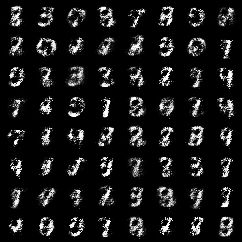



Starting Training Loop...
[18/50][0/469]	Loss_D: 0.1869	Loss_G: 1.9043	D(x): 0.9982	D(G(z)): 0.1690 / 0.1489
[18/50][50/469]	Loss_D: 1.3454	Loss_G: 0.5236	D(x): 0.7744	D(G(z)): 0.6637 / 0.5924
[18/50][100/469]	Loss_D: 0.2021	Loss_G: 3.7741	D(x): 0.8393	D(G(z)): 0.0265 / 0.0230
[18/50][150/469]	Loss_D: 0.3546	Loss_G: 1.4221	D(x): 0.9523	D(G(z)): 0.2634 / 0.2412
[18/50][200/469]	Loss_D: 0.3167	Loss_G: 1.6095	D(x): 0.9893	D(G(z)): 0.2636 / 0.2000
[18/50][250/469]	Loss_D: 0.4248	Loss_G: 1.2030	D(x): 1.0000	D(G(z)): 0.3461 / 0.3003
[18/50][300/469]	Loss_D: 0.1263	Loss_G: 2.6462	D(x): 0.9724	D(G(z)): 0.0936 / 0.0709
[18/50][350/469]	Loss_D: 3.0627	Loss_G: 0.3327	D(x): 0.2455	D(G(z)): 0.8095 / 0.7170
[18/50][400/469]	Loss_D: 0.2065	Loss_G: 2.8326	D(x): 0.8681	D(G(z)): 0.0631 / 0.0589
[18/50][450/469]	Loss_D: 0.7627	Loss_G: 0.8480	D(x): 0.9823	D(G(z)): 0.5252 / 0.4283
Starting Training Loop...
Sample of generated images


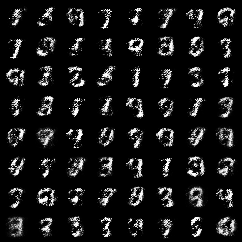



Starting Training Loop...
[19/50][0/469]	Loss_D: 1.7286	Loss_G: 0.4655	D(x): 0.6339	D(G(z)): 0.7199 / 0.6278
[19/50][50/469]	Loss_D: 0.1105	Loss_G: 2.5173	D(x): 0.9959	D(G(z)): 0.1009 / 0.0807
[19/50][100/469]	Loss_D: 0.0559	Loss_G: 3.1055	D(x): 0.9986	D(G(z)): 0.0531 / 0.0448
[19/50][150/469]	Loss_D: 2.9625	Loss_G: 1.7329	D(x): 0.0652	D(G(z)): 0.2073 / 0.1768
[19/50][200/469]	Loss_D: 0.1958	Loss_G: 3.1401	D(x): 0.8642	D(G(z)): 0.0485 / 0.0433
[19/50][250/469]	Loss_D: 0.6395	Loss_G: 1.0330	D(x): 0.9974	D(G(z)): 0.4711 / 0.3559
[19/50][300/469]	Loss_D: 3.6523	Loss_G: 3.0579	D(x): 0.0271	D(G(z)): 0.0435 / 0.0470
[19/50][350/469]	Loss_D: 0.3248	Loss_G: 1.5541	D(x): 0.9478	D(G(z)): 0.2375 / 0.2114
[19/50][400/469]	Loss_D: 0.3430	Loss_G: 2.8348	D(x): 0.7521	D(G(z)): 0.0564 / 0.0587
[19/50][450/469]	Loss_D: 0.1092	Loss_G: 2.7245	D(x): 0.9953	D(G(z)): 0.0992 / 0.0656
Starting Training Loop...
Sample of generated images


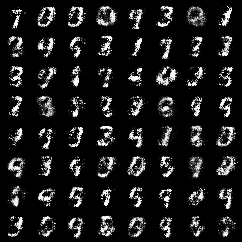



Starting Training Loop...
[20/50][0/469]	Loss_D: 2.5875	Loss_G: 0.1366	D(x): 0.6956	D(G(z)): 0.8919 / 0.8723
[20/50][50/469]	Loss_D: 0.7584	Loss_G: 0.8047	D(x): 0.9989	D(G(z)): 0.5311 / 0.4472
[20/50][100/469]	Loss_D: 2.4138	Loss_G: 1.9006	D(x): 0.1031	D(G(z)): 0.1320 / 0.1495
[20/50][150/469]	Loss_D: 2.6481	Loss_G: 2.8213	D(x): 0.0751	D(G(z)): 0.0580 / 0.0595
[20/50][200/469]	Loss_D: 0.0102	Loss_G: 4.7426	D(x): 0.9998	D(G(z)): 0.0099 / 0.0087
[20/50][250/469]	Loss_D: 0.5343	Loss_G: 1.8894	D(x): 0.6950	D(G(z)): 0.1568 / 0.1512
[20/50][300/469]	Loss_D: 0.1907	Loss_G: 2.1639	D(x): 0.9705	D(G(z)): 0.1485 / 0.1149
[20/50][350/469]	Loss_D: 0.1042	Loss_G: 2.7351	D(x): 0.9687	D(G(z)): 0.0699 / 0.0649
[20/50][400/469]	Loss_D: 0.4402	Loss_G: 1.7129	D(x): 0.8109	D(G(z)): 0.2059 / 0.1803
[20/50][450/469]	Loss_D: 0.4725	Loss_G: 1.1516	D(x): 0.9908	D(G(z)): 0.3708 / 0.3161
Starting Training Loop...
Sample of generated images


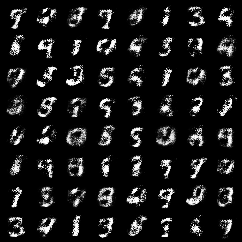



Starting Training Loop...
[21/50][0/469]	Loss_D: 1.3297	Loss_G: 0.5501	D(x): 0.9461	D(G(z)): 0.7204 / 0.5769
[21/50][50/469]	Loss_D: 0.6860	Loss_G: 0.9585	D(x): 0.8963	D(G(z)): 0.4381 / 0.3835
[21/50][100/469]	Loss_D: 1.3157	Loss_G: 3.6579	D(x): 0.2759	D(G(z)): 0.0275 / 0.0258
[21/50][150/469]	Loss_D: 0.2970	Loss_G: 2.1364	D(x): 0.8453	D(G(z)): 0.1210 / 0.1181
[21/50][200/469]	Loss_D: 1.2759	Loss_G: 1.3617	D(x): 0.3834	D(G(z)): 0.2719 / 0.2562
[21/50][250/469]	Loss_D: 0.0457	Loss_G: 4.0119	D(x): 0.9714	D(G(z)): 0.0165 / 0.0181
[21/50][300/469]	Loss_D: 1.1267	Loss_G: 2.1288	D(x): 0.3703	D(G(z)): 0.1248 / 0.1190
[21/50][350/469]	Loss_D: 1.7037	Loss_G: 0.8614	D(x): 0.3655	D(G(z)): 0.5021 / 0.4226
[21/50][400/469]	Loss_D: 2.8588	Loss_G: 0.1106	D(x): 0.9999	D(G(z)): 0.9427 / 0.8953
[21/50][450/469]	Loss_D: 0.3877	Loss_G: 1.3347	D(x): 0.9861	D(G(z)): 0.3118 / 0.2632
Starting Training Loop...
Sample of generated images


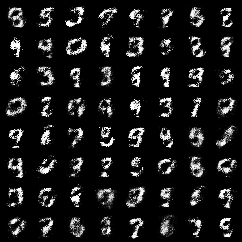



Starting Training Loop...
[22/50][0/469]	Loss_D: 0.1955	Loss_G: 1.6860	D(x): 0.9880	D(G(z)): 0.1676 / 0.1853
[22/50][50/469]	Loss_D: 5.0076	Loss_G: 0.2504	D(x): 0.0351	D(G(z)): 0.8097 / 0.7785
[22/50][100/469]	Loss_D: 0.4701	Loss_G: 1.1079	D(x): 0.9642	D(G(z)): 0.3519 / 0.3303
[22/50][150/469]	Loss_D: 0.1768	Loss_G: 1.8790	D(x): 0.9990	D(G(z)): 0.1612 / 0.1527
[22/50][200/469]	Loss_D: 1.3332	Loss_G: 0.4551	D(x): 0.9712	D(G(z)): 0.7285 / 0.6344
[22/50][250/469]	Loss_D: 1.0392	Loss_G: 0.9560	D(x): 0.9145	D(G(z)): 0.6132 / 0.3844
[22/50][300/469]	Loss_D: 0.4224	Loss_G: 2.7022	D(x): 0.7120	D(G(z)): 0.0794 / 0.0671
[22/50][350/469]	Loss_D: 1.6377	Loss_G: 0.8230	D(x): 0.3703	D(G(z)): 0.4750 / 0.4391
[22/50][400/469]	Loss_D: 0.2430	Loss_G: 2.8057	D(x): 0.8378	D(G(z)): 0.0638 / 0.0605
[22/50][450/469]	Loss_D: 0.1601	Loss_G: 2.8256	D(x): 0.9044	D(G(z)): 0.0579 / 0.0593
Starting Training Loop...
Sample of generated images


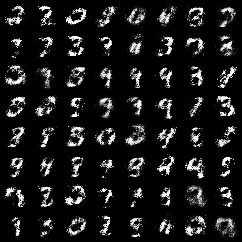



Starting Training Loop...
[23/50][0/469]	Loss_D: 1.4449	Loss_G: 0.7627	D(x): 0.4693	D(G(z)): 0.4976 / 0.4664
[23/50][50/469]	Loss_D: 0.2323	Loss_G: 2.6556	D(x): 0.8619	D(G(z)): 0.0803 / 0.0703
[23/50][100/469]	Loss_D: 0.2760	Loss_G: 1.7246	D(x): 0.9433	D(G(z)): 0.1956 / 0.1782
[23/50][150/469]	Loss_D: 0.1905	Loss_G: 1.9734	D(x): 0.9978	D(G(z)): 0.1717 / 0.1390
[23/50][200/469]	Loss_D: 0.6243	Loss_G: 0.9127	D(x): 0.9855	D(G(z)): 0.4565 / 0.4014
[23/50][250/469]	Loss_D: 2.0179	Loss_G: 1.9599	D(x): 0.1524	D(G(z)): 0.1279 / 0.1409
[23/50][300/469]	Loss_D: 0.5734	Loss_G: 1.6983	D(x): 0.7262	D(G(z)): 0.2239 / 0.1830
[23/50][350/469]	Loss_D: 3.5337	Loss_G: 0.9216	D(x): 0.0527	D(G(z)): 0.4461 / 0.3979
[23/50][400/469]	Loss_D: 4.1271	Loss_G: 0.9649	D(x): 0.0313	D(G(z)): 0.4850 / 0.3810
[23/50][450/469]	Loss_D: 0.7789	Loss_G: 2.2459	D(x): 0.5204	D(G(z)): 0.1181 / 0.1058
Starting Training Loop...
Sample of generated images


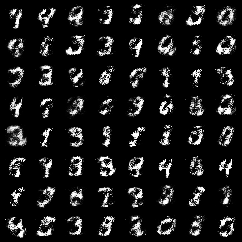



Starting Training Loop...
[24/50][0/469]	Loss_D: 0.2668	Loss_G: 1.5726	D(x): 0.9975	D(G(z)): 0.2322 / 0.2075
[24/50][50/469]	Loss_D: 0.9082	Loss_G: 1.4599	D(x): 0.5741	D(G(z)): 0.2977 / 0.2323
[24/50][100/469]	Loss_D: 0.0983	Loss_G: 2.5832	D(x): 0.9994	D(G(z)): 0.0931 / 0.0755
[24/50][150/469]	Loss_D: 1.8011	Loss_G: 0.5778	D(x): 0.4558	D(G(z)): 0.6378 / 0.5611
[24/50][200/469]	Loss_D: 0.2469	Loss_G: 2.2254	D(x): 0.8770	D(G(z)): 0.1093 / 0.1080
[24/50][250/469]	Loss_D: 0.3598	Loss_G: 1.8798	D(x): 0.8611	D(G(z)): 0.1896 / 0.1526
[24/50][300/469]	Loss_D: 1.2774	Loss_G: 0.7668	D(x): 0.5493	D(G(z)): 0.4925 / 0.4645
[24/50][350/469]	Loss_D: 0.2185	Loss_G: 3.9455	D(x): 0.8222	D(G(z)): 0.0224 / 0.0193
[24/50][400/469]	Loss_D: 0.4288	Loss_G: 1.1543	D(x): 0.9943	D(G(z)): 0.3450 / 0.3153
[24/50][450/469]	Loss_D: 0.1629	Loss_G: 2.6309	D(x): 0.9297	D(G(z)): 0.0860 / 0.0720
Starting Training Loop...
Sample of generated images


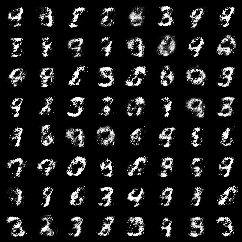



Starting Training Loop...
[25/50][0/469]	Loss_D: 0.0194	Loss_G: 4.0515	D(x): 0.9990	D(G(z)): 0.0182 / 0.0174
[25/50][50/469]	Loss_D: 0.8958	Loss_G: 0.6591	D(x): 0.9993	D(G(z)): 0.5914 / 0.5173
[25/50][100/469]	Loss_D: 0.2199	Loss_G: 1.7746	D(x): 1.0000	D(G(z)): 0.1974 / 0.1696
[25/50][150/469]	Loss_D: 0.3524	Loss_G: 2.3376	D(x): 0.8119	D(G(z)): 0.1341 / 0.0966
[25/50][200/469]	Loss_D: 0.3810	Loss_G: 1.8859	D(x): 0.8435	D(G(z)): 0.1901 / 0.1517
[25/50][250/469]	Loss_D: 1.0537	Loss_G: 0.9057	D(x): 0.7232	D(G(z)): 0.5179 / 0.4043
[25/50][300/469]	Loss_D: 0.0945	Loss_G: 2.8125	D(x): 0.9712	D(G(z)): 0.0632 / 0.0601
[25/50][350/469]	Loss_D: 0.0828	Loss_G: 2.7837	D(x): 0.9988	D(G(z)): 0.0784 / 0.0618
[25/50][400/469]	Loss_D: 0.3146	Loss_G: 1.7732	D(x): 0.9505	D(G(z)): 0.2319 / 0.1698
[25/50][450/469]	Loss_D: 0.0670	Loss_G: 3.8540	D(x): 0.9582	D(G(z)): 0.0240 / 0.0212
Starting Training Loop...
Sample of generated images


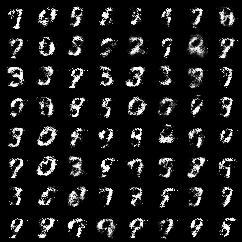



Starting Training Loop...
[26/50][0/469]	Loss_D: 1.7934	Loss_G: 2.4289	D(x): 0.1835	D(G(z)): 0.0933 / 0.0881
[26/50][50/469]	Loss_D: 0.0878	Loss_G: 3.2033	D(x): 0.9603	D(G(z)): 0.0462 / 0.0406
[26/50][100/469]	Loss_D: 0.2081	Loss_G: 2.0580	D(x): 1.0000	D(G(z)): 0.1878 / 0.1277
[26/50][150/469]	Loss_D: 0.4859	Loss_G: 1.2084	D(x): 0.9974	D(G(z)): 0.3833 / 0.2987
[26/50][200/469]	Loss_D: 1.7635	Loss_G: 0.5417	D(x): 0.5891	D(G(z)): 0.7090 / 0.5818
[26/50][250/469]	Loss_D: 0.1281	Loss_G: 2.1513	D(x): 0.9987	D(G(z)): 0.1190 / 0.1163
[26/50][300/469]	Loss_D: 1.9666	Loss_G: 0.2666	D(x): 0.9908	D(G(z)): 0.8588 / 0.7660
[26/50][350/469]	Loss_D: 1.8660	Loss_G: 2.1744	D(x): 0.1750	D(G(z)): 0.1157 / 0.1137
[26/50][400/469]	Loss_D: 0.6487	Loss_G: 0.8816	D(x): 0.9705	D(G(z)): 0.4614 / 0.4141
[26/50][450/469]	Loss_D: 0.0819	Loss_G: 5.5676	D(x): 0.9257	D(G(z)): 0.0047 / 0.0038
Starting Training Loop...
Sample of generated images


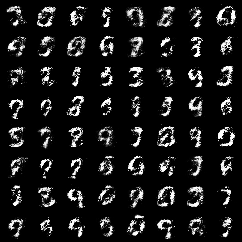



Starting Training Loop...
[27/50][0/469]	Loss_D: 1.1238	Loss_G: 0.5929	D(x): 0.9526	D(G(z)): 0.6588 / 0.5527
[27/50][50/469]	Loss_D: 0.5293	Loss_G: 1.6576	D(x): 0.7637	D(G(z)): 0.2288 / 0.1906
[27/50][100/469]	Loss_D: 0.6716	Loss_G: 0.9379	D(x): 0.9858	D(G(z)): 0.4818 / 0.3915
[27/50][150/469]	Loss_D: 0.9325	Loss_G: 2.7833	D(x): 0.4159	D(G(z)): 0.0537 / 0.0618
[27/50][200/469]	Loss_D: 0.6272	Loss_G: 2.8396	D(x): 0.5686	D(G(z)): 0.0607 / 0.0584
[27/50][250/469]	Loss_D: 0.2239	Loss_G: 1.8991	D(x): 1.0000	D(G(z)): 0.2006 / 0.1497
[27/50][300/469]	Loss_D: 0.3471	Loss_G: 1.4092	D(x): 0.9926	D(G(z)): 0.2880 / 0.2443
[27/50][350/469]	Loss_D: 0.9976	Loss_G: 2.9033	D(x): 0.3915	D(G(z)): 0.0580 / 0.0548
[27/50][400/469]	Loss_D: 1.0507	Loss_G: 0.6044	D(x): 0.9108	D(G(z)): 0.6161 / 0.5464
[27/50][450/469]	Loss_D: 0.1960	Loss_G: 1.7314	D(x): 0.9999	D(G(z)): 0.1780 / 0.1770
Starting Training Loop...
Sample of generated images


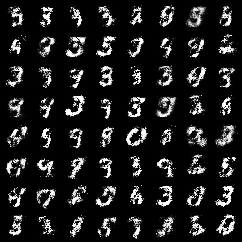



Starting Training Loop...
[28/50][0/469]	Loss_D: 0.3441	Loss_G: 1.6115	D(x): 0.9220	D(G(z)): 0.2311 / 0.1996
[28/50][50/469]	Loss_D: 2.2510	Loss_G: 0.2413	D(x): 1.0000	D(G(z)): 0.8947 / 0.7856
[28/50][100/469]	Loss_D: 0.3756	Loss_G: 1.3041	D(x): 0.9872	D(G(z)): 0.3042 / 0.2714
[28/50][150/469]	Loss_D: 0.7066	Loss_G: 0.7864	D(x): 0.9999	D(G(z)): 0.5066 / 0.4555
[28/50][200/469]	Loss_D: 0.2426	Loss_G: 2.0358	D(x): 0.9955	D(G(z)): 0.2119 / 0.1306
[28/50][250/469]	Loss_D: 0.4863	Loss_G: 2.7777	D(x): 0.6583	D(G(z)): 0.0660 / 0.0622
[28/50][300/469]	Loss_D: 0.3354	Loss_G: 3.4648	D(x): 0.7411	D(G(z)): 0.0351 / 0.0313
[28/50][350/469]	Loss_D: 0.7945	Loss_G: 0.9308	D(x): 0.9983	D(G(z)): 0.5474 / 0.3943
[28/50][400/469]	Loss_D: 1.6216	Loss_G: 2.9467	D(x): 0.2091	D(G(z)): 0.0551 / 0.0525
[28/50][450/469]	Loss_D: 2.7579	Loss_G: 1.1735	D(x): 0.0884	D(G(z)): 0.2828 / 0.3093
Starting Training Loop...
Sample of generated images


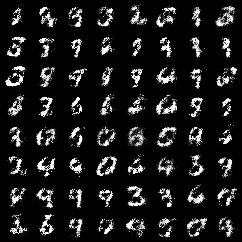



Starting Training Loop...
[29/50][0/469]	Loss_D: 0.2089	Loss_G: 2.2341	D(x): 0.9307	D(G(z)): 0.1281 / 0.1071
[29/50][50/469]	Loss_D: 0.1711	Loss_G: 2.1999	D(x): 0.9727	D(G(z)): 0.1336 / 0.1108
[29/50][100/469]	Loss_D: 0.2380	Loss_G: 2.0205	D(x): 0.9797	D(G(z)): 0.1955 / 0.1326
[29/50][150/469]	Loss_D: 2.1942	Loss_G: 1.8476	D(x): 0.1297	D(G(z)): 0.1406 / 0.1576
[29/50][200/469]	Loss_D: 0.1005	Loss_G: 2.6106	D(x): 0.9998	D(G(z)): 0.0954 / 0.0735
[29/50][250/469]	Loss_D: 0.2938	Loss_G: 1.5163	D(x): 0.9520	D(G(z)): 0.2170 / 0.2195
[29/50][300/469]	Loss_D: 0.0549	Loss_G: 3.5137	D(x): 0.9796	D(G(z)): 0.0338 / 0.0298
[29/50][350/469]	Loss_D: 0.8938	Loss_G: 1.8815	D(x): 0.4793	D(G(z)): 0.1464 / 0.1524
[29/50][400/469]	Loss_D: 0.3109	Loss_G: 1.4193	D(x): 0.9982	D(G(z)): 0.2659 / 0.2419
[29/50][450/469]	Loss_D: 0.7148	Loss_G: 0.7829	D(x): 0.9869	D(G(z)): 0.5043 / 0.4571
Starting Training Loop...
Sample of generated images


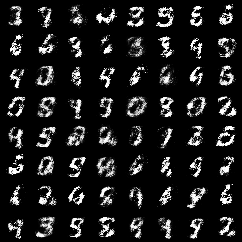



Starting Training Loop...
[30/50][0/469]	Loss_D: 2.0898	Loss_G: 2.3118	D(x): 0.1367	D(G(z)): 0.0949 / 0.0991
[30/50][50/469]	Loss_D: 0.2145	Loss_G: 1.9255	D(x): 0.9723	D(G(z)): 0.1700 / 0.1458
[30/50][100/469]	Loss_D: 2.3235	Loss_G: 3.0112	D(x): 0.1025	D(G(z)): 0.0450 / 0.0492
[30/50][150/469]	Loss_D: 1.9772	Loss_G: 0.7852	D(x): 0.3148	D(G(z)): 0.5602 / 0.4560
[30/50][200/469]	Loss_D: 0.5303	Loss_G: 1.0971	D(x): 0.9030	D(G(z)): 0.3484 / 0.3338
[30/50][250/469]	Loss_D: 0.6917	Loss_G: 3.2371	D(x): 0.5218	D(G(z)): 0.0404 / 0.0393
[30/50][300/469]	Loss_D: 0.2955	Loss_G: 4.0198	D(x): 0.7567	D(G(z)): 0.0166 / 0.0180
[30/50][350/469]	Loss_D: 5.4605	Loss_G: 0.4557	D(x): 0.0129	D(G(z)): 0.6693 / 0.6340
[30/50][400/469]	Loss_D: 1.3398	Loss_G: 1.9631	D(x): 0.3032	D(G(z)): 0.1362 / 0.1404
[30/50][450/469]	Loss_D: 0.8495	Loss_G: 1.0887	D(x): 0.7099	D(G(z)): 0.3976 / 0.3366
Starting Training Loop...
Sample of generated images


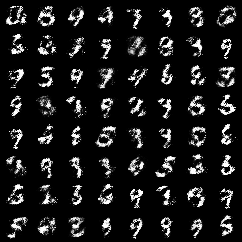



Starting Training Loop...
[31/50][0/469]	Loss_D: 2.7732	Loss_G: 0.8530	D(x): 0.1151	D(G(z)): 0.4572 / 0.4261
[31/50][50/469]	Loss_D: 1.5761	Loss_G: 0.8764	D(x): 0.4249	D(G(z)): 0.5134 / 0.4163
[31/50][100/469]	Loss_D: 0.0218	Loss_G: 4.4621	D(x): 0.9916	D(G(z)): 0.0132 / 0.0115
[31/50][150/469]	Loss_D: 0.0297	Loss_G: 3.5786	D(x): 0.9998	D(G(z)): 0.0290 / 0.0279
[31/50][200/469]	Loss_D: 0.4380	Loss_G: 1.2622	D(x): 0.9994	D(G(z)): 0.3542 / 0.2830
[31/50][250/469]	Loss_D: 0.1930	Loss_G: 2.4642	D(x): 0.9035	D(G(z)): 0.0875 / 0.0851
[31/50][300/469]	Loss_D: 2.2529	Loss_G: 0.6674	D(x): 0.2869	D(G(z)): 0.6337 / 0.5130
[31/50][350/469]	Loss_D: 1.3532	Loss_G: 1.8291	D(x): 0.3069	D(G(z)): 0.1580 / 0.1606
[31/50][400/469]	Loss_D: 0.2186	Loss_G: 2.2388	D(x): 0.8994	D(G(z)): 0.1065 / 0.1066
[31/50][450/469]	Loss_D: 0.7076	Loss_G: 1.3472	D(x): 0.6960	D(G(z)): 0.2919 / 0.2600
Starting Training Loop...
Sample of generated images


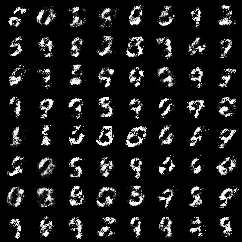



Starting Training Loop...
[32/50][0/469]	Loss_D: 3.2747	Loss_G: 3.3045	D(x): 0.0394	D(G(z)): 0.0402 / 0.0367
[32/50][50/469]	Loss_D: 1.2420	Loss_G: 0.5782	D(x): 0.9756	D(G(z)): 0.7040 / 0.5609
[32/50][100/469]	Loss_D: 0.1341	Loss_G: 3.1562	D(x): 0.9149	D(G(z)): 0.0441 / 0.0426
[32/50][150/469]	Loss_D: 0.3264	Loss_G: 1.4109	D(x): 0.9985	D(G(z)): 0.2774 / 0.2439
[32/50][200/469]	Loss_D: 0.6945	Loss_G: 1.0300	D(x): 0.8769	D(G(z)): 0.4306 / 0.3570
[32/50][250/469]	Loss_D: 0.4348	Loss_G: 1.9502	D(x): 0.7603	D(G(z)): 0.1485 / 0.1422
[32/50][300/469]	Loss_D: 0.3561	Loss_G: 2.4901	D(x): 0.7702	D(G(z)): 0.0906 / 0.0829
[32/50][350/469]	Loss_D: 0.0338	Loss_G: 3.5980	D(x): 0.9939	D(G(z)): 0.0272 / 0.0274
[32/50][400/469]	Loss_D: 0.5635	Loss_G: 2.2621	D(x): 0.6404	D(G(z)): 0.1111 / 0.1041
[32/50][450/469]	Loss_D: 0.1312	Loss_G: 2.5750	D(x): 0.9558	D(G(z)): 0.0824 / 0.0762
Starting Training Loop...
Sample of generated images


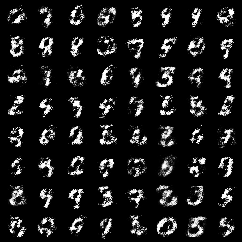



Starting Training Loop...
[33/50][0/469]	Loss_D: 0.7293	Loss_G: 1.7365	D(x): 0.6077	D(G(z)): 0.2065 / 0.1761
[33/50][50/469]	Loss_D: 0.0738	Loss_G: 2.7069	D(x): 0.9960	D(G(z)): 0.0674 / 0.0667
[33/50][100/469]	Loss_D: 0.8507	Loss_G: 1.0533	D(x): 0.7278	D(G(z)): 0.4131 / 0.3488
[33/50][150/469]	Loss_D: 1.9451	Loss_G: 1.2179	D(x): 0.2072	D(G(z)): 0.3099 / 0.2958
[33/50][200/469]	Loss_D: 1.4959	Loss_G: 4.7474	D(x): 0.2260	D(G(z)): 0.0088 / 0.0087
[33/50][250/469]	Loss_D: 0.2842	Loss_G: 1.5874	D(x): 0.9901	D(G(z)): 0.2398 / 0.2045
[33/50][300/469]	Loss_D: 0.5550	Loss_G: 3.1115	D(x): 0.5987	D(G(z)): 0.0412 / 0.0445
[33/50][350/469]	Loss_D: 0.0640	Loss_G: 2.9852	D(x): 0.9917	D(G(z)): 0.0541 / 0.0505
[33/50][400/469]	Loss_D: 0.2362	Loss_G: 1.7163	D(x): 1.0000	D(G(z)): 0.2103 / 0.1797
[33/50][450/469]	Loss_D: 2.6034	Loss_G: 0.2554	D(x): 0.4062	D(G(z)): 0.8178 / 0.7746
Starting Training Loop...
Sample of generated images


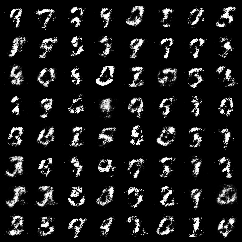



Starting Training Loop...
[34/50][0/469]	Loss_D: 0.1007	Loss_G: 2.4779	D(x): 0.9988	D(G(z)): 0.0947 / 0.0839
[34/50][50/469]	Loss_D: 0.3235	Loss_G: 1.9977	D(x): 0.8505	D(G(z)): 0.1492 / 0.1356
[34/50][100/469]	Loss_D: 0.8096	Loss_G: 1.3485	D(x): 0.6181	D(G(z)): 0.2800 / 0.2596
[34/50][150/469]	Loss_D: 0.0488	Loss_G: 3.1832	D(x): 0.9954	D(G(z)): 0.0432 / 0.0415
[34/50][200/469]	Loss_D: 0.2362	Loss_G: 1.7432	D(x): 0.9986	D(G(z)): 0.2093 / 0.1750
[34/50][250/469]	Loss_D: 0.0990	Loss_G: 3.6219	D(x): 0.9331	D(G(z)): 0.0293 / 0.0267
[34/50][300/469]	Loss_D: 0.1003	Loss_G: 2.5773	D(x): 0.9997	D(G(z)): 0.0952 / 0.0760
[34/50][350/469]	Loss_D: 1.2008	Loss_G: 1.6390	D(x): 0.3868	D(G(z)): 0.2219 / 0.1942
[34/50][400/469]	Loss_D: 1.4038	Loss_G: 2.0761	D(x): 0.2839	D(G(z)): 0.1345 / 0.1254
[34/50][450/469]	Loss_D: 0.1075	Loss_G: 3.5287	D(x): 0.9249	D(G(z)): 0.0290 / 0.0293
Starting Training Loop...
Sample of generated images


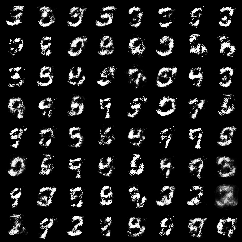



Starting Training Loop...
[35/50][0/469]	Loss_D: 1.5871	Loss_G: 0.3392	D(x): 1.0000	D(G(z)): 0.7955 / 0.7124
[35/50][50/469]	Loss_D: 3.2161	Loss_G: 4.2948	D(x): 0.0407	D(G(z)): 0.0138 / 0.0136
[35/50][100/469]	Loss_D: 0.5656	Loss_G: 0.9650	D(x): 0.9705	D(G(z)): 0.4147 / 0.3810
[35/50][150/469]	Loss_D: 2.5986	Loss_G: 1.1982	D(x): 0.1106	D(G(z)): 0.3277 / 0.3017
[35/50][200/469]	Loss_D: 0.3492	Loss_G: 2.7207	D(x): 0.7536	D(G(z)): 0.0642 / 0.0658
[35/50][250/469]	Loss_D: 1.5033	Loss_G: 2.1198	D(x): 0.2522	D(G(z)): 0.1181 / 0.1201
[35/50][300/469]	Loss_D: 0.8990	Loss_G: 2.1565	D(x): 0.4625	D(G(z)): 0.1201 / 0.1157
[35/50][350/469]	Loss_D: 0.2788	Loss_G: 1.4600	D(x): 0.9988	D(G(z)): 0.2424 / 0.2322
[35/50][400/469]	Loss_D: 0.0754	Loss_G: 2.8061	D(x): 0.9918	D(G(z)): 0.0650 / 0.0604
[35/50][450/469]	Loss_D: 0.8199	Loss_G: 1.0335	D(x): 0.7195	D(G(z)): 0.3878 / 0.3558
Starting Training Loop...
Sample of generated images


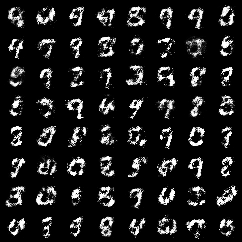



Starting Training Loop...
[36/50][0/469]	Loss_D: 1.2331	Loss_G: 2.6591	D(x): 0.3161	D(G(z)): 0.0782 / 0.0700
[36/50][50/469]	Loss_D: 0.5247	Loss_G: 3.1580	D(x): 0.6183	D(G(z)): 0.0430 / 0.0425
[36/50][100/469]	Loss_D: 0.1834	Loss_G: 2.1281	D(x): 0.9592	D(G(z)): 0.1322 / 0.1191
[36/50][150/469]	Loss_D: 0.5077	Loss_G: 2.5811	D(x): 0.6520	D(G(z)): 0.0769 / 0.0757
[36/50][200/469]	Loss_D: 0.1686	Loss_G: 4.5023	D(x): 0.8548	D(G(z)): 0.0117 / 0.0111
[36/50][250/469]	Loss_D: 0.2303	Loss_G: 2.2168	D(x): 0.9006	D(G(z)): 0.1180 / 0.1090
[36/50][300/469]	Loss_D: 1.4145	Loss_G: 1.4776	D(x): 0.3153	D(G(z)): 0.2291 / 0.2282
[36/50][350/469]	Loss_D: 0.4112	Loss_G: 1.3518	D(x): 0.9085	D(G(z)): 0.2703 / 0.2588
[36/50][400/469]	Loss_D: 0.3104	Loss_G: 1.9481	D(x): 0.8618	D(G(z)): 0.1493 / 0.1425
[36/50][450/469]	Loss_D: 0.3525	Loss_G: 1.9864	D(x): 0.8232	D(G(z)): 0.1461 / 0.1372
Starting Training Loop...
Sample of generated images


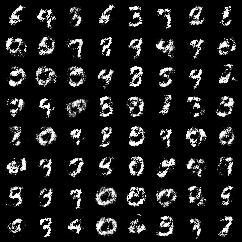



Starting Training Loop...
[37/50][0/469]	Loss_D: 0.0828	Loss_G: 3.0735	D(x): 0.9749	D(G(z)): 0.0558 / 0.0463
[37/50][50/469]	Loss_D: 0.8766	Loss_G: 1.5357	D(x): 0.5571	D(G(z)): 0.2529 / 0.2153
[37/50][100/469]	Loss_D: 0.7961	Loss_G: 0.9105	D(x): 0.9109	D(G(z)): 0.5048 / 0.4023
[37/50][150/469]	Loss_D: 0.7720	Loss_G: 1.7233	D(x): 0.5645	D(G(z)): 0.1815 / 0.1785
[37/50][200/469]	Loss_D: 0.1244	Loss_G: 2.8213	D(x): 0.9452	D(G(z)): 0.0657 / 0.0595
[37/50][250/469]	Loss_D: 2.8782	Loss_G: 1.9048	D(x): 0.0676	D(G(z)): 0.1675 / 0.1488
[37/50][300/469]	Loss_D: 0.0801	Loss_G: 2.6282	D(x): 0.9922	D(G(z)): 0.0697 / 0.0722
[37/50][350/469]	Loss_D: 3.7707	Loss_G: 0.0836	D(x): 0.4331	D(G(z)): 0.9468 / 0.9198
[37/50][400/469]	Loss_D: 0.5413	Loss_G: 1.8657	D(x): 0.6889	D(G(z)): 0.1552 / 0.1548
[37/50][450/469]	Loss_D: 0.7442	Loss_G: 1.5487	D(x): 0.6289	D(G(z)): 0.2446 / 0.2125
Starting Training Loop...
Sample of generated images


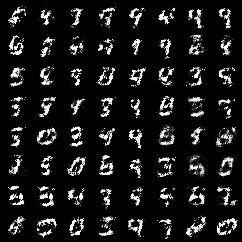



Starting Training Loop...
[38/50][0/469]	Loss_D: 5.0298	Loss_G: 0.9515	D(x): 0.0112	D(G(z)): 0.4152 / 0.3862
[38/50][50/469]	Loss_D: 0.1351	Loss_G: 3.2298	D(x): 0.9128	D(G(z)): 0.0429 / 0.0396
[38/50][100/469]	Loss_D: 0.0879	Loss_G: 3.1228	D(x): 0.9646	D(G(z)): 0.0506 / 0.0440
[38/50][150/469]	Loss_D: 0.5131	Loss_G: 1.6466	D(x): 0.7663	D(G(z)): 0.2188 / 0.1927
[38/50][200/469]	Loss_D: 0.0755	Loss_G: 3.8256	D(x): 0.9506	D(G(z)): 0.0246 / 0.0218
[38/50][250/469]	Loss_D: 0.5067	Loss_G: 0.9375	D(x): 0.9897	D(G(z)): 0.3912 / 0.3916
[38/50][300/469]	Loss_D: 0.8201	Loss_G: 3.4180	D(x): 0.4577	D(G(z)): 0.0377 / 0.0328
[38/50][350/469]	Loss_D: 2.9444	Loss_G: 2.5963	D(x): 0.0568	D(G(z)): 0.0735 / 0.0745
[38/50][400/469]	Loss_D: 0.6183	Loss_G: 1.4406	D(x): 0.7103	D(G(z)): 0.2413 / 0.2368
[38/50][450/469]	Loss_D: 0.0216	Loss_G: 3.9015	D(x): 0.9980	D(G(z)): 0.0194 / 0.0202
Starting Training Loop...
Sample of generated images


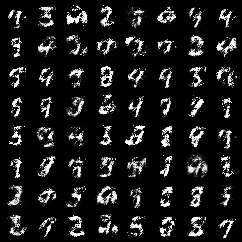



Starting Training Loop...
[39/50][0/469]	Loss_D: 0.2097	Loss_G: 1.9963	D(x): 0.9541	D(G(z)): 0.1501 / 0.1358
[39/50][50/469]	Loss_D: 0.0897	Loss_G: 2.9116	D(x): 0.9713	D(G(z)): 0.0587 / 0.0544
[39/50][100/469]	Loss_D: 0.0695	Loss_G: 2.8158	D(x): 0.9932	D(G(z)): 0.0607 / 0.0599
[39/50][150/469]	Loss_D: 1.5548	Loss_G: 0.7375	D(x): 0.4442	D(G(z)): 0.5244 / 0.4783
[39/50][200/469]	Loss_D: 1.5758	Loss_G: 0.3894	D(x): 0.9401	D(G(z)): 0.7800 / 0.6775
[39/50][250/469]	Loss_D: 0.2959	Loss_G: 1.5775	D(x): 0.9560	D(G(z)): 0.2219 / 0.2065
[39/50][300/469]	Loss_D: 3.2010	Loss_G: 1.1116	D(x): 0.0609	D(G(z)): 0.3308 / 0.3290
[39/50][350/469]	Loss_D: 1.4713	Loss_G: 0.3367	D(x): 0.9994	D(G(z)): 0.7702 / 0.7141
[39/50][400/469]	Loss_D: 1.0845	Loss_G: 2.7777	D(x): 0.3607	D(G(z)): 0.0627 / 0.0622
[39/50][450/469]	Loss_D: 0.2491	Loss_G: 1.6360	D(x): 0.9858	D(G(z)): 0.2092 / 0.1948
Starting Training Loop...
Sample of generated images


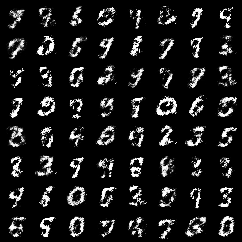



Starting Training Loop...
[40/50][0/469]	Loss_D: 0.0797	Loss_G: 4.3011	D(x): 0.9369	D(G(z)): 0.0144 / 0.0136
[40/50][50/469]	Loss_D: 0.2109	Loss_G: 2.7431	D(x): 0.8666	D(G(z)): 0.0654 / 0.0644
[40/50][100/469]	Loss_D: 0.5249	Loss_G: 1.9885	D(x): 0.7009	D(G(z)): 0.1558 / 0.1369
[40/50][150/469]	Loss_D: 0.1531	Loss_G: 2.1687	D(x): 0.9837	D(G(z)): 0.1277 / 0.1143
[40/50][200/469]	Loss_D: 0.7543	Loss_G: 2.5544	D(x): 0.5122	D(G(z)): 0.0817 / 0.0777
[40/50][250/469]	Loss_D: 0.6149	Loss_G: 1.2159	D(x): 0.7936	D(G(z)): 0.3186 / 0.2964
[40/50][300/469]	Loss_D: 1.2252	Loss_G: 1.0676	D(x): 0.4571	D(G(z)): 0.3575 / 0.3438
[40/50][350/469]	Loss_D: 2.5719	Loss_G: 0.2544	D(x): 0.4475	D(G(z)): 0.8293 / 0.7754
[40/50][400/469]	Loss_D: 0.7419	Loss_G: 1.0186	D(x): 0.8127	D(G(z)): 0.4140 / 0.3611
[40/50][450/469]	Loss_D: 1.5609	Loss_G: 0.4678	D(x): 0.7359	D(G(z)): 0.7147 / 0.6264
Starting Training Loop...
Sample of generated images


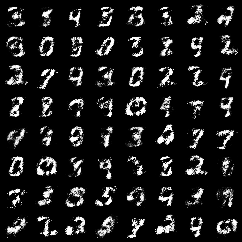



Starting Training Loop...
[41/50][0/469]	Loss_D: 0.5302	Loss_G: 2.5567	D(x): 0.6405	D(G(z)): 0.0811 / 0.0776
[41/50][50/469]	Loss_D: 0.8815	Loss_G: 1.8654	D(x): 0.4954	D(G(z)): 0.1640 / 0.1548
[41/50][100/469]	Loss_D: 0.2688	Loss_G: 1.7534	D(x): 0.9367	D(G(z)): 0.1841 / 0.1732
[41/50][150/469]	Loss_D: 1.3625	Loss_G: 0.8785	D(x): 0.4702	D(G(z)): 0.4556 / 0.4154
[41/50][200/469]	Loss_D: 1.1886	Loss_G: 3.6705	D(x): 0.3127	D(G(z)): 0.0258 / 0.0255
[41/50][250/469]	Loss_D: 2.5413	Loss_G: 0.5446	D(x): 0.2438	D(G(z)): 0.6769 / 0.5801
[41/50][300/469]	Loss_D: 1.3461	Loss_G: 1.3592	D(x): 0.3535	D(G(z)): 0.2638 / 0.2569
[41/50][350/469]	Loss_D: 1.7194	Loss_G: 0.3691	D(x): 0.6848	D(G(z)): 0.7384 / 0.6914
[41/50][400/469]	Loss_D: 0.2087	Loss_G: 1.6960	D(x): 0.9999	D(G(z)): 0.1883 / 0.1834
[41/50][450/469]	Loss_D: 0.4859	Loss_G: 1.1042	D(x): 0.9796	D(G(z)): 0.3720 / 0.3315
Starting Training Loop...
Sample of generated images


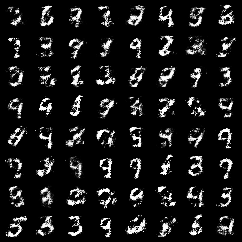



Starting Training Loop...
[42/50][0/469]	Loss_D: 0.5256	Loss_G: 0.9977	D(x): 1.0000	D(G(z)): 0.4088 / 0.3687
[42/50][50/469]	Loss_D: 0.5783	Loss_G: 2.7688	D(x): 0.5998	D(G(z)): 0.0649 / 0.0627
[42/50][100/469]	Loss_D: 2.2418	Loss_G: 0.3487	D(x): 0.5367	D(G(z)): 0.8020 / 0.7056
[42/50][150/469]	Loss_D: 1.1615	Loss_G: 1.9284	D(x): 0.3755	D(G(z)): 0.1664 / 0.1454
[42/50][200/469]	Loss_D: 0.2541	Loss_G: 1.7139	D(x): 0.9708	D(G(z)): 0.2011 / 0.1802
[42/50][250/469]	Loss_D: 0.0546	Loss_G: 3.1757	D(x): 0.9918	D(G(z)): 0.0453 / 0.0418
[42/50][300/469]	Loss_D: 1.5527	Loss_G: 2.8280	D(x): 0.2245	D(G(z)): 0.0571 / 0.0591
[42/50][350/469]	Loss_D: 0.4387	Loss_G: 1.1750	D(x): 0.9998	D(G(z)): 0.3550 / 0.3088
[42/50][400/469]	Loss_D: 2.2252	Loss_G: 0.1718	D(x): 0.8092	D(G(z)): 0.8665 / 0.8422
[42/50][450/469]	Loss_D: 0.9571	Loss_G: 0.7316	D(x): 0.8046	D(G(z)): 0.5227 / 0.4811
Starting Training Loop...
Sample of generated images


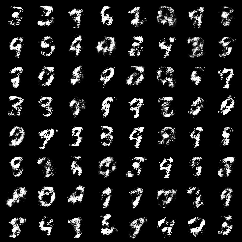



Starting Training Loop...
[43/50][0/469]	Loss_D: 2.9753	Loss_G: 0.4326	D(x): 0.1840	D(G(z)): 0.7227 / 0.6488
[43/50][50/469]	Loss_D: 0.2125	Loss_G: 1.7648	D(x): 0.9925	D(G(z)): 0.1854 / 0.1712
[43/50][100/469]	Loss_D: 0.6114	Loss_G: 1.1075	D(x): 0.8622	D(G(z)): 0.3707 / 0.3304
[43/50][150/469]	Loss_D: 2.4644	Loss_G: 0.1720	D(x): 0.9147	D(G(z)): 0.9070 / 0.8420
[43/50][200/469]	Loss_D: 0.0976	Loss_G: 3.0027	D(x): 0.9548	D(G(z)): 0.0501 / 0.0497
[43/50][250/469]	Loss_D: 1.3150	Loss_G: 0.9554	D(x): 0.4534	D(G(z)): 0.4078 / 0.3847
[43/50][300/469]	Loss_D: 0.1517	Loss_G: 2.0598	D(x): 0.9996	D(G(z)): 0.1404 / 0.1275
[43/50][350/469]	Loss_D: 0.1276	Loss_G: 2.4699	D(x): 0.9633	D(G(z)): 0.0863 / 0.0846
[43/50][400/469]	Loss_D: 0.1829	Loss_G: 1.8345	D(x): 0.9993	D(G(z)): 0.1665 / 0.1597
[43/50][450/469]	Loss_D: 1.6364	Loss_G: 0.9954	D(x): 0.4640	D(G(z)): 0.5804 / 0.3696
Starting Training Loop...
Sample of generated images


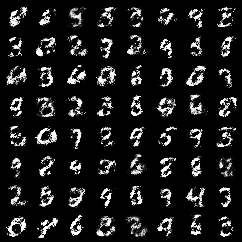



Starting Training Loop...
[44/50][0/469]	Loss_D: 0.2908	Loss_G: 1.7124	D(x): 0.9313	D(G(z)): 0.1972 / 0.1804
[44/50][50/469]	Loss_D: 2.8103	Loss_G: 0.1734	D(x): 0.9263	D(G(z)): 0.9350 / 0.8408
[44/50][100/469]	Loss_D: 0.9059	Loss_G: 1.7258	D(x): 0.5124	D(G(z)): 0.2111 / 0.1780
[44/50][150/469]	Loss_D: 0.1043	Loss_G: 2.4632	D(x): 0.9978	D(G(z)): 0.0971 / 0.0852
[44/50][200/469]	Loss_D: 0.6828	Loss_G: 0.8581	D(x): 0.9755	D(G(z)): 0.4821 / 0.4240
[44/50][250/469]	Loss_D: 1.2858	Loss_G: 1.2417	D(x): 0.3924	D(G(z)): 0.2956 / 0.2889
[44/50][300/469]	Loss_D: 0.1242	Loss_G: 2.8453	D(x): 0.9502	D(G(z)): 0.0706 / 0.0581
[44/50][350/469]	Loss_D: 0.4713	Loss_G: 1.1609	D(x): 0.9666	D(G(z)): 0.3542 / 0.3132
[44/50][400/469]	Loss_D: 0.6965	Loss_G: 1.7541	D(x): 0.6364	D(G(z)): 0.2169 / 0.1731
[44/50][450/469]	Loss_D: 0.8328	Loss_G: 0.7480	D(x): 0.9906	D(G(z)): 0.5611 / 0.4733
Starting Training Loop...
Sample of generated images


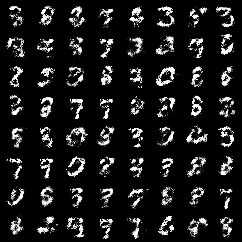



Starting Training Loop...
[45/50][0/469]	Loss_D: 0.2309	Loss_G: 1.7963	D(x): 0.9902	D(G(z)): 0.1983 / 0.1659
[45/50][50/469]	Loss_D: 1.7994	Loss_G: 0.2870	D(x): 1.0000	D(G(z)): 0.8346 / 0.7505
[45/50][100/469]	Loss_D: 1.5962	Loss_G: 0.9209	D(x): 0.3488	D(G(z)): 0.4190 / 0.3982
[45/50][150/469]	Loss_D: 1.7477	Loss_G: 1.6838	D(x): 0.2172	D(G(z)): 0.1983 / 0.1857
[45/50][200/469]	Loss_D: 2.2869	Loss_G: 0.2236	D(x): 0.9209	D(G(z)): 0.8897 / 0.7996
[45/50][250/469]	Loss_D: 0.7223	Loss_G: 0.7189	D(x): 0.9991	D(G(z)): 0.5139 / 0.4873
[45/50][300/469]	Loss_D: 2.1651	Loss_G: 0.2395	D(x): 0.6652	D(G(z)): 0.8275 / 0.7870
[45/50][350/469]	Loss_D: 0.5003	Loss_G: 1.1876	D(x): 0.9349	D(G(z)): 0.3515 / 0.3050
[45/50][400/469]	Loss_D: 0.3934	Loss_G: 2.6993	D(x): 0.7244	D(G(z)): 0.0685 / 0.0673
[45/50][450/469]	Loss_D: 0.6679	Loss_G: 0.8948	D(x): 1.0000	D(G(z)): 0.4872 / 0.4087
Starting Training Loop...
Sample of generated images


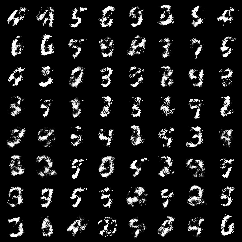



Starting Training Loop...
[46/50][0/469]	Loss_D: 0.5598	Loss_G: 1.1650	D(x): 0.9254	D(G(z)): 0.3826 / 0.3119
[46/50][50/469]	Loss_D: 1.3100	Loss_G: 0.3953	D(x): 0.9624	D(G(z)): 0.7196 / 0.6735
[46/50][100/469]	Loss_D: 0.4748	Loss_G: 3.6198	D(x): 0.6392	D(G(z)): 0.0269 / 0.0268
[46/50][150/469]	Loss_D: 0.9288	Loss_G: 1.2200	D(x): 0.5966	D(G(z)): 0.3378 / 0.2952
[46/50][200/469]	Loss_D: 1.4162	Loss_G: 1.6948	D(x): 0.2971	D(G(z)): 0.1832 / 0.1836
[46/50][250/469]	Loss_D: 0.1734	Loss_G: 2.6392	D(x): 0.9080	D(G(z)): 0.0741 / 0.0714
[46/50][300/469]	Loss_D: 2.6169	Loss_G: 0.4367	D(x): 0.2587	D(G(z)): 0.7177 / 0.6461
[46/50][350/469]	Loss_D: 0.0296	Loss_G: 3.8425	D(x): 0.9965	D(G(z)): 0.0258 / 0.0214
[46/50][400/469]	Loss_D: 2.5673	Loss_G: 3.0787	D(x): 0.0807	D(G(z)): 0.0488 / 0.0460
[46/50][450/469]	Loss_D: 0.1081	Loss_G: 2.3301	D(x): 0.9912	D(G(z)): 0.0945 / 0.0973
Starting Training Loop...
Sample of generated images


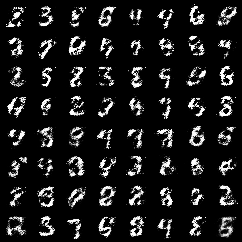



Starting Training Loop...
[47/50][0/469]	Loss_D: 2.0018	Loss_G: 0.4535	D(x): 0.4520	D(G(z)): 0.7011 / 0.6354
[47/50][50/469]	Loss_D: 0.3833	Loss_G: 2.5185	D(x): 0.7406	D(G(z)): 0.0797 / 0.0806
[47/50][100/469]	Loss_D: 0.0115	Loss_G: 4.5952	D(x): 0.9989	D(G(z)): 0.0104 / 0.0101
[47/50][150/469]	Loss_D: 2.4556	Loss_G: 0.4708	D(x): 0.2560	D(G(z)): 0.6648 / 0.6245
[47/50][200/469]	Loss_D: 0.9394	Loss_G: 0.7980	D(x): 0.7777	D(G(z)): 0.4974 / 0.4502
[47/50][250/469]	Loss_D: 1.0420	Loss_G: 1.8924	D(x): 0.4229	D(G(z)): 0.1659 / 0.1507
[47/50][300/469]	Loss_D: 0.4503	Loss_G: 1.8597	D(x): 0.7581	D(G(z)): 0.1592 / 0.1557
[47/50][350/469]	Loss_D: 0.1735	Loss_G: 3.0804	D(x): 0.8844	D(G(z)): 0.0494 / 0.0459
[47/50][400/469]	Loss_D: 1.4687	Loss_G: 3.2961	D(x): 0.2386	D(G(z)): 0.0352 / 0.0370
[47/50][450/469]	Loss_D: 0.0252	Loss_G: 4.2273	D(x): 0.9915	D(G(z)): 0.0165 / 0.0146
Starting Training Loop...
Sample of generated images


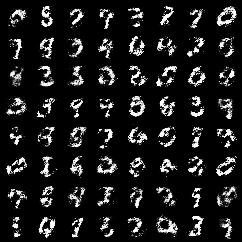



Starting Training Loop...
[48/50][0/469]	Loss_D: 0.3540	Loss_G: 1.9091	D(x): 0.8368	D(G(z)): 0.1612 / 0.1482
[48/50][50/469]	Loss_D: 0.7078	Loss_G: 1.0390	D(x): 0.8246	D(G(z)): 0.4025 / 0.3538
[48/50][100/469]	Loss_D: 0.1281	Loss_G: 2.4673	D(x): 0.9708	D(G(z)): 0.0938 / 0.0848
[48/50][150/469]	Loss_D: 1.6986	Loss_G: 0.7776	D(x): 0.3957	D(G(z)): 0.5377 / 0.4595
[48/50][200/469]	Loss_D: 0.8224	Loss_G: 3.1301	D(x): 0.4603	D(G(z)): 0.0454 / 0.0437
[48/50][250/469]	Loss_D: 2.9151	Loss_G: 2.2733	D(x): 0.0611	D(G(z)): 0.1124 / 0.1030
[48/50][300/469]	Loss_D: 1.3386	Loss_G: 2.9861	D(x): 0.2758	D(G(z)): 0.0493 / 0.0505
[48/50][350/469]	Loss_D: 0.4236	Loss_G: 1.2107	D(x): 0.9532	D(G(z)): 0.3131 / 0.2980
[48/50][400/469]	Loss_D: 1.1158	Loss_G: 2.2363	D(x): 0.3660	D(G(z)): 0.1048 / 0.1069
[48/50][450/469]	Loss_D: 0.0922	Loss_G: 2.7034	D(x): 0.9793	D(G(z)): 0.0688 / 0.0670
Starting Training Loop...
Sample of generated images


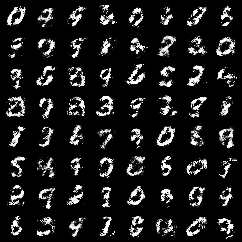



Starting Training Loop...
[49/50][0/469]	Loss_D: 0.2984	Loss_G: 1.3998	D(x): 0.9911	D(G(z)): 0.2513 / 0.2466
[49/50][50/469]	Loss_D: 0.7944	Loss_G: 0.8740	D(x): 0.7802	D(G(z)): 0.4209 / 0.4173
[49/50][100/469]	Loss_D: 0.0786	Loss_G: 4.3286	D(x): 0.9366	D(G(z)): 0.0131 / 0.0132
[49/50][150/469]	Loss_D: 1.0465	Loss_G: 2.2159	D(x): 0.3924	D(G(z)): 0.1050 / 0.1091
[49/50][200/469]	Loss_D: 1.6979	Loss_G: 2.4263	D(x): 0.2012	D(G(z)): 0.0901 / 0.0884
[49/50][250/469]	Loss_D: 1.2285	Loss_G: 0.6437	D(x): 0.7675	D(G(z)): 0.6186 / 0.5253
[49/50][300/469]	Loss_D: 0.0140	Loss_G: 5.7788	D(x): 0.9890	D(G(z)): 0.0029 / 0.0031
[49/50][350/469]	Loss_D: 0.2248	Loss_G: 2.2813	D(x): 0.8997	D(G(z)): 0.1123 / 0.1022
[49/50][400/469]	Loss_D: 0.5214	Loss_G: 1.6544	D(x): 0.7469	D(G(z)): 0.2051 / 0.1912
[49/50][450/469]	Loss_D: 0.7728	Loss_G: 0.7436	D(x): 0.9979	D(G(z)): 0.5373 / 0.4754
Starting Training Loop...
Sample of generated images


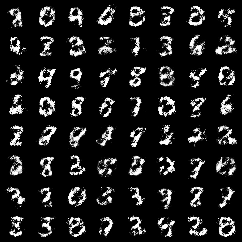



Starting Training Loop...
[50/50][0/469]	Loss_D: 0.6554	Loss_G: 1.4929	D(x): 0.6888	D(G(z)): 0.2462 / 0.2247
[50/50][50/469]	Loss_D: 1.3921	Loss_G: 1.3481	D(x): 0.3402	D(G(z)): 0.2694 / 0.2597
[50/50][100/469]	Loss_D: 0.4763	Loss_G: 1.8409	D(x): 0.7487	D(G(z)): 0.1705 / 0.1587
[50/50][150/469]	Loss_D: 0.4920	Loss_G: 4.0255	D(x): 0.6225	D(G(z)): 0.0178 / 0.0179
[50/50][200/469]	Loss_D: 0.8453	Loss_G: 1.9260	D(x): 0.5036	D(G(z)): 0.1473 / 0.1457
[50/50][250/469]	Loss_D: 3.0022	Loss_G: 0.4308	D(x): 0.1793	D(G(z)): 0.7229 / 0.6500
[50/50][300/469]	Loss_D: 0.1835	Loss_G: 2.1965	D(x): 0.9496	D(G(z)): 0.1234 / 0.1112
[50/50][350/469]	Loss_D: 0.7110	Loss_G: 0.7727	D(x): 0.9996	D(G(z)): 0.5086 / 0.4618
[50/50][400/469]	Loss_D: 0.9828	Loss_G: 0.7626	D(x): 0.8481	D(G(z)): 0.5587 / 0.4665
[50/50][450/469]	Loss_D: 0.1159	Loss_G: 2.7578	D(x): 0.9563	D(G(z)): 0.0688 / 0.0634
Starting Training Loop...
Sample of generated images


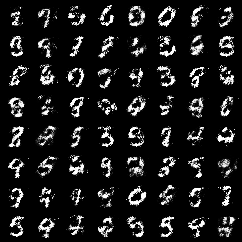

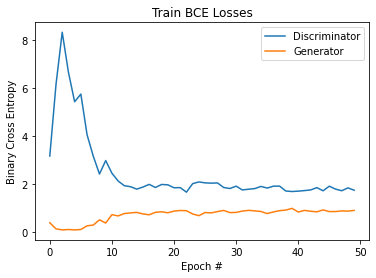

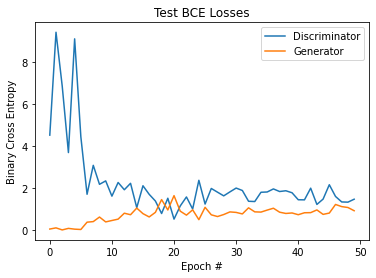

In [41]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


From generated images, we can see GAN generated much better quality images compared to VAE. Especially as epoch increases, GAN can produce more clear and higher quality images, but VAE generate lower quality images. In details, VAE produces images which contains many blurry and even blanks, it only produces some repeated digits like 1's and 9's but GAN can generate more variety of digits and with high quality (very clear, easy to recognize). 

GAN consists of Generator and Discriminator, Discriminator tries to predict the label as accuratly as possible as the true labels, however, Generator tries its best to fool discriminator by generating fake images as similar to true images as possible, and then discriminator continue try its best to distinguish between fake and real images but this time it will be much harder. The two parts will compete with each other and as a result images generated from Generator will be more realistic and similiar to training images.

As we can see from training and Test BCE Losses, at most of time, Discriminator consistently yields loss higher than Generator, I think the reason is Loss for discriminator is log(D(x)) + log(1 - D(G(z))) for Generator is log(D(G(z))), so discriminator need to distinguish both real and fake images, so loss will be higher, Generator only make loss if discriminator can't pick fake images. For both training and testing loss, Generator starts with 0 and increases and converged eventually, this means Discriminator's ability improved so it is harder for Generator to make fake images.I noticed that Discriminator and Generator moves in opposite way, e.g if Discriminator increases, Generator decreases at the same epoch, because Discriminator and Generator compete with each other, one's loss is the other's gain. As epoch close to 50, both Generator's loss and Discriminator's loss converged to a similar value which is close to 1.   

